In [ ]:
# Welcome to your new notebook
# Type here in the cell editor to add code!
http://api.open-notify.org/iss-now.json



In [1]:
%pip install azure-eventhub

StatementMeta(, 0f530165-fca5-4b6b-b78b-2ede9a08406c, 7, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.1/325.1 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Not uninstalling typing-extensions at /home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages, outside environment /nfs4/pyenv-34105d82-ccc6-4d72-8061-1d0f55b46ce7
    Can't uninstall 'typing_extensions'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 2.0.0 requires sentencepiece, which is not installed.
sentence-transformers 2.0.0 requires torchvision, which is not installed.
dash 2.14.0 requires Flask<2.3.0,>=1.0.4, but you have flask 3.0.0 which is incompatible.
dash 2.14.0 requires Werkzeug<2.3.0, but you have werkzeug 3.0.1 which is incompatible.
tensorflow 2.12.1 requires typing-extensions<4.6.0

In [2]:
%pip install apscheduler

StatementMeta(, 0f530165-fca5-4b6b-b78b-2ede9a08406c, 13, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 4.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



### Request

In [3]:
import requests

response = requests.get("http://api.open-notify.org/iss-now.json")

# Print the status code of the response.
print(response.status_code)
print(response.content)

StatementMeta(, 0f530165-fca5-4b6b-b78b-2ede9a08406c, 15, Finished, Available, Finished)

200
b'{"timestamp": 1726051846, "message": "success", "iss_position": {"latitude": "-27.5408", "longitude": "-61.2031"}}'


### Libraries


In [4]:
##Libraries
import requests
from azure.eventhub import EventHubProducerClient, EventData
import time
from apscheduler.schedulers.blocking import BlockingScheduler
import json

StatementMeta(, 0f530165-fca5-4b6b-b78b-2ede9a08406c, 16, Finished, Available, Finished)

### Data Streaming to the Event Streaming

In [5]:


# Function to get ISS data and send it to Azure Event Hub
def send_iss_data():
    try:
        # Make a GET request to get the latest position of the ISS from the opennotify API
        response = requests.get("http://api.open-notify.org/iss-now.json")

        if response.status_code == 200:
            
            iss_data = response.json()

            # Convert iss_data to JSON string
            iss_data_json = json.dumps(iss_data)

            # Send data to Azure Event Hub
            eventhub_connection_str = (
                f"Endpoint=sb://esehwestuiy6nlrtxx94tjp0.servicebus.windows.net/;SharedAccessKeyName=key_d6f0cc67-af7e-a352-1d83-22e1128fff0d;SharedAccessKey=umWK1u7I/RQVWr3zuUFT106Qh6HuqNpG8+AEhKRsA/8=;EntityPath=es_fa31d11f-c702-4d57-9760-959d08651607"
                
            )
            
            producer = EventHubProducerClient.from_connection_string(eventhub_connection_str)

            with producer:
                event_data_batch = producer.create_batch()

                # Add the event data to the batch
                event_data_batch.add(EventData(body=iss_data_json))

                # Send the batch to the event hub
                producer.send_batch(event_data_batch)

            print("Data sent to Azure Event Hub successfully.")
        else:
            print(f"Failed to retrieve ISS data. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error: {str(e)}")

###https://learn.microsoft.com/en-us/fabric/real-time-analytics/event-streams/overview#various-source-connectors

# Set up a scheduler to run the function every 5 seconds
scheduler = BlockingScheduler()
scheduler.add_job(send_iss_data, 'interval', seconds=5)

try:
    scheduler.start()
except (KeyboardInterrupt, SystemExit):
    print("Scheduler stopped.")

###https://learn.microsoft.com/en-us/fabric/real-time-analytics/event-streams/overview#various-source-connectors

StatementMeta(, 0f530165-fca5-4b6b-b78b-2ede9a08406c, 17, Submitted, Running, Running)

Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent to Azure Event Hub successfully.
Data sent t

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime
import pandas as pd

# Read the Delta table
iss_positions_spark = spark.sql("SELECT * FROM LH_ES.ES_STREAM  LIMIT 1000")

# Show the DataFrame schema and data
iss_positions_spark.printSchema()
iss_positions_spark.show(truncate=False)

# Convert the timestamp to a human-readable format
iss_positions_spark = iss_positions_spark.withColumn("timestamp", from_unixtime(col("timestamp")))

# Extract latitude, longitude, and timestamp from the JSON column
iss_positions_spark = iss_positions_spark.withColumn("latitude", col("iss_position.latitude").cast("double"))
iss_positions_spark = iss_positions_spark.withColumn("longitude", col("iss_position.longitude").cast("double"))

# Select relevant columns
iss_position_df = iss_positions_spark.select("latitude", "longitude", "timestamp")

# Convert to Pandas DataFrame
iss_position_df_pandas = iss_position_df.toPandas()

# Show the Pandas DataFrame
print(iss_position_df_pandas)

StatementMeta(, 3e975a16-5801-41db-9603-9d1c4f8f2f39, 9, Finished, Available)

root
 |-- iss_position: struct (nullable = true)
 |    |-- latitude: string (nullable = true)
 |    |-- longitude: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- message: string (nullable = true)
 |-- EventProcessedUtcTime: timestamp (nullable = true)
 |-- PartitionId: long (nullable = true)
 |-- EventEnqueuedUtcTime: timestamp (nullable = true)

+--------------------+----------+-------+--------------------------+-----------+-----------------------+
|iss_position        |timestamp |message|EventProcessedUtcTime     |PartitionId|EventEnqueuedUtcTime   |
+--------------------+----------+-------+--------------------------+-----------+-----------------------+
|{-19.4857, 97.7079} |1702043110|success|2023-12-08 13:46:28.651692|1          |2023-12-08 13:45:11.252|
|{-20.2150, 98.3256} |1702043125|success|2023-12-08 13:46:28.752624|1          |2023-12-08 13:45:26.237|
|{-21.4242, 99.3693} |1702043150|success|2023-12-08 13:46:28.753657|1          |2023-12-08 13:45:51.256|

StatementMeta(, 3e975a16-5801-41db-9603-9d1c4f8f2f39, 14, Finished, Available)

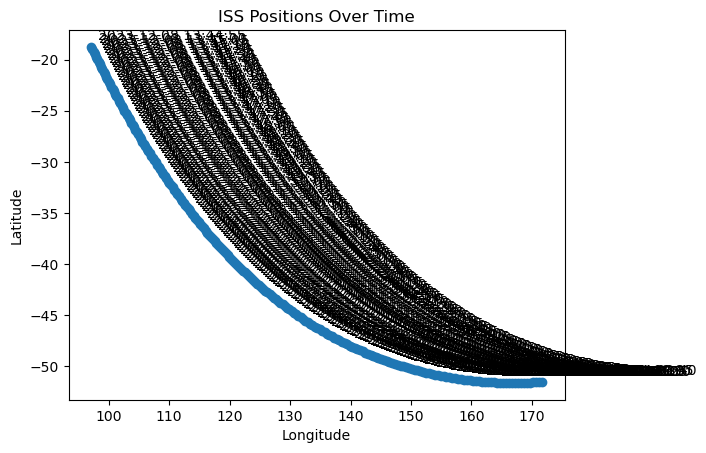

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame called iss_position_df_pandas with 'latitude', 'longitude', and 'timestamp' columns

# Create a scatter plot using Matplotlib
plt.scatter(iss_position_df_pandas['longitude'], iss_position_df_pandas['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ISS Positions Over Time')

# Annotate points with timestamps
for index, row in iss_position_df_pandas.iterrows():
    plt.annotate(row['timestamp'], (row['longitude'], row['latitude']), textcoords="offset points", xytext=(5,5), ha='left')

plt.show()
